# Imports

In [211]:
#!pip install -U scikit-learn

In [212]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [213]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [214]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [215]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [216]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [217]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[5.37400852 5.37539251 5.37402193 ... 1.68829352 4.84464055 1.68857894]
[11.70244363 11.7054574  11.70247283 ...  3.67642882 10.54969168
  3.67705034]
[0.99999974 0.99999975 0.99999974 ... 0.99158138 0.99999886 0.99158811]
(5999,)


### Multinomial Sampling

In [218]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 1 1 0]


In [219]:
target_number_triangles = 10
target_number_point = min(len(graph._node), target_number_triangles*3)   # number of points for the simplification     #TODO Change to nb of triangles

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(75.20536, -5.5423326, 83.15385), (39.0, 8.048206, 93.55898), (39.0, -8.774797, -5.665533), (75.13281, 1.9813722, 3.6171947), (84.17619, 3.5589852, -10.330094), (39.0, 7.4193583, 94.73214), (86.10441, 8.492921, 16.7), (77.139755, 8.672658, -6.2667465), (80.31322, -8.447791, 84.650444), (87.40501, -0.99710757, -8.605006), (63.0, -1.1623888, 81.27711), (81.614365, 8.722893, 85.01881), (86.10441, 8.492921, 68.3), (83.99175, -8.760632, 0.34839013), (39.0, 8.642877, 91.6555), (80.21036, 8.237194, 83.5198), (79.4965, 7.6759295, 81.2), (76.30896, -6.0434117, 1.7843841), (80.20638, -3.5589852, -12.223597), (77.57679, -8.447791, -1.98757), (77.87872, -6.5098743, 81.2), (89.7515, -4.1574683, 88.71626), (82.130325, -8.722893, 1.062925), (87.957466, 7.755995, 29.6), (88.354774, 5.7970243, 88.910385), (80.12535, 8.447791, 84.92379), (75.0, 8.114116, -8.406043), (75.07118, 1.3272538, 81.27118), (76.21072, 8.348472, 92.71918), (75.38077, 2.6241417, 81.32372)]


# KNN

In [220]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[75.20536, -5.5423326, 83.15385], [39.0, 8.048206, 93.55898], [39.0, -8.774797, -5.665533], [75.13281, 1.9813722, 3.6171947], [84.17619, 3.5589852, -10.330094], [39.0, 7.4193583, 94.73214], [86.10441, 8.492921, 16.7], [77.139755, 8.672658, -6.2667465], [80.31322, -8.447791, 84.650444], [87.40501, -0.99710757, -8.605006], [63.0, -1.1623888, 81.27711], [81.614365, 8.722893, 85.01881], [86.10441, 8.492921, 68.3], [83.99175, -8.760632, 0.34839013], [39.0, 8.642877, 91.6555], [80.21036, 8.237194, 83.5198], [79.4965, 7.6759295, 81.2], [76.30896, -6.0434117, 1.7843841], [80.20638, -3.5589852, -12.223597], [77.57679, -8.447791, -1.98757], [77.87872, -6.5098743, 81.2], [89.7515, -4.1574683, 88.71626], [82.130325, -8.722893, 1.062925], [87.957466, 7.755995, 29.6], [88.354774, 5.7970243, 88.910385], [80.12535, 8.447791, 84.92379], [75.0, 8.114116, -8.406043], [75.07118, 1.3272538, 81.27118], [76.21072, 8.348472, 92.71918], [75.38077, 2.6241417, 81.32372]]


In [221]:
def connect_extended_graph(XYZ, number_neigh=15):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [222]:
extended_graph = connect_extended_graph(XYZ)

Number of nodes: 30
Number of edges: 299


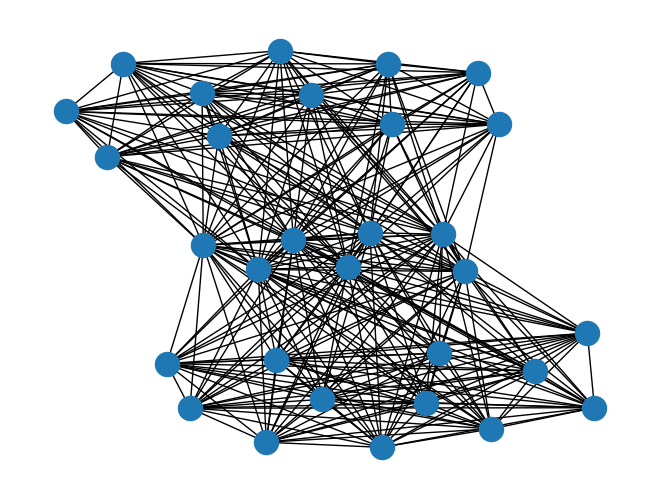

In [223]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [224]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(30, 64)


In [225]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean


f1i = np.mean(inclusion_score)
f1j = np.mean(inclusion_score)
wq = np.random.randint(100, size=(64,1))
wk = np.random.randint(100, size=(1,64))

f1i_wq = f1i*wq
f1j_wk = f1j*wk

wq_wk = int(np.matmul(f1j_wk, f1i_wq)) 

expo = np.exp(wq_wk)



C:\Users\Arthur\AppData\Local\Temp\ipykernel_3436\73126498.py:21: RuntimeWarning: overflow encountered in exp
  expo = np.exp(wq_wk)


### Sparse Attention

# Face Candidates

#### Inputs

In [226]:
adjacency = nx.adjacency_matrix(extended_graph)
S = np.random.rand(target_number_point, target_number_point)
print(adjacency)
print(S)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	1
  (0, 16)	1
  (0, 29)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	1
  (1, 8)	1
  :	:
  (29, 1)	1
  (29, 2)	1
  (29, 3)	1
  (29, 4)	1
  (29, 5)	1
  (29, 6)	1
  (29, 7)	1
  (29, 8)	1
  (29, 9)	1
  (29, 10)	1
  (29, 11)	1
  (29, 12)	1
  (29, 13)	1
  (29, 17)	1
  (29, 18)	1
  (29, 19)	1
  (29, 20)	1
  (29, 21)	1
  (29, 22)	1
  (29, 23)	1
  (29, 24)	1
  (29, 25)	1
  (29, 26)	1
  (29, 27)	1
  (29, 28)	1
[[0.73421456 0.94761854 0.46792839 0.51097247 0.77409897 0.89551536
  0.52406181 0.82258645 0.95000884 0.06332635 0.12115209 0.75169852
  0.15846346 0.10163865 0.15426907 0.75929697 0.53519755 0.07159208
  0.43860873 0.27718499 0.74123361 0.14544466 0.52287066 0.34887536
  0.15205352 0.14015777 0.05193105 0.12046495 0.51823818 0.11409944]
 [0.41220389 0.3523727  0.58966886 0.30040771 0.766543

In [227]:
A_s = np.zeros((target_number_point,target_number_point))

for i in range(target_number_point):
    for j in range(target_number_point):
        A_s[i,j] = np.matmul(np.matmul(S[i,:], adjacency.A), S[j,:][np.newaxis].T)

print(A_s)  # symmétrique
print(A_s.shape)

[[119.14782799 148.67418728 119.65792927 159.84255933 121.91236889
  112.89622764 111.53201681 145.99643027 125.75426046 135.16324483
  147.87018665 133.26349366 132.81653422 116.48686423 139.40925606
  143.12997345 118.88481003 119.69547542 152.17109203 136.57719782
  127.0937746  125.6969068  146.59459845 135.9422341  114.25033906
  122.62942345 142.58464755 144.33056234 141.05221855 137.03042557]
 [148.67418728 190.62386301 146.83471469 203.21847946 155.52612913
  139.47968745 139.02886068 182.05819484 149.00947812 164.82268539
  179.79222384 164.27312766 166.66055927 148.50093199 175.17724783
  174.3984977  156.05294201 148.72325083 184.51657685 174.69330427
  159.52745998 161.91183099 189.30878874 172.55215896 147.04050277
  157.86483227 178.16259703 188.17382172 174.16142086 170.96731393]
 [119.65792927 146.83471469 115.06734991 158.57585877 121.52599073
  110.32430106 109.9049349  144.0230868  121.80413681 134.07390391
  143.43968814 131.44481658 130.90912575 115.46194767 137.28

c:\Users\Arthur\miniconda3\envs\meshPFE\lib\site-packages\scipy\sparse\_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


# Face Classifier

### TriConv

#### Inputs

In [228]:
triangles = list(nx.simple_cycles(extended_graph, length_bound=3))  # [triangle0, triangle1,...] | triangle0 = [node1,node2,node3] | node1 = (x ,y ,z)
print(triangles)
print(np.array(triangles).shape)    #nb_triangle, 3 nodes, 3 dimensions par node

[[(75.20536, -5.5423326, 83.15385), (77.87872, -6.5098743, 81.2), (80.31322, -8.447791, 84.650444)], [(75.20536, -5.5423326, 83.15385), (77.87872, -6.5098743, 81.2), (75.07118, 1.3272538, 81.27118)], [(75.20536, -5.5423326, 83.15385), (77.87872, -6.5098743, 81.2), (75.38077, 2.6241417, 81.32372)], [(75.20536, -5.5423326, 83.15385), (77.87872, -6.5098743, 81.2), (63.0, -1.1623888, 81.27711)], [(75.20536, -5.5423326, 83.15385), (77.87872, -6.5098743, 81.2), (79.4965, 7.6759295, 81.2)], [(75.20536, -5.5423326, 83.15385), (77.87872, -6.5098743, 81.2), (80.21036, 8.237194, 83.5198)], [(75.20536, -5.5423326, 83.15385), (77.87872, -6.5098743, 81.2), (80.12535, 8.447791, 84.92379)], [(75.20536, -5.5423326, 83.15385), (77.87872, -6.5098743, 81.2), (89.7515, -4.1574683, 88.71626)], [(75.20536, -5.5423326, 83.15385), (77.87872, -6.5098743, 81.2), (81.614365, 8.722893, 85.01881)], [(75.20536, -5.5423326, 83.15385), (77.87872, -6.5098743, 81.2), (76.21072, 8.348472, 92.71918)], [(75.20536, -5.54233

In [229]:
p_init = np.zeros((len(triangles)))

for index_triangle, triangle in enumerate(triangles):
    i = list(dict(extended_graph._node).keys()).index(triangle[0])
    j = list(dict(extended_graph._node).keys()).index(triangle[1])
    k = list(dict(extended_graph._node).keys()).index(triangle[2])
    p_init[index_triangle] = (A_s[i,j] + A_s[i,k] + A_s[j,k])/3
print(p_init)

[138.38894375 170.57840869 142.03756177 ... 132.25737557 147.8538975
 145.63755493]


#### Calculate barycenter

In [230]:
barycenters = list()

for _, triangle in enumerate(triangles):
    b_x = (triangle[0][0] + triangle[1][0] + triangle[2][0]) / 3
    b_y = (triangle[0][1] + triangle[1][1] + triangle[2][1]) / 3
    b_z = (triangle[0][2] + triangle[1][2] + triangle[2][2]) / 3
    barycenters.append([b_x, b_y, b_z])

print(barycenters)
print(len(barycenters))

[[77.79909769694011, -6.833332697550456, 83.00143432617188], [76.05175272623698, -3.5749842325846353, 81.87501017252605], [76.15494791666667, -3.142688433329264, 81.8925272623698], [72.0280253092448, -4.404865264892578, 81.87698364257812], [77.52685546875, -1.4587591489156086, 81.85128275553386], [77.76481119791667, -1.271670977274577, 82.62455240885417], [77.73647562662761, -1.2014719645182292, 83.09254964192708], [80.9451904296875, -5.403224945068359, 84.35670471191406], [78.23281351725261, -1.1097714106241863, 83.1242167154948], [76.43159993489583, -1.2345784505208333, 85.69100952148438], [80.4796142578125, -2.0850609143575034, 84.42141215006511], [79.7294921875, -1.186428705851237, 77.55128479003906], [64.0280253092448, -1.1364434560139973, 85.33644612630208], [64.0280253092448, -1.3346668879191081, 85.970947265625], [64.0280253092448, -1.5442829132080078, 86.36199951171875], [80.34717814127605, -1.4320707321166992, 64.65128580729167], [76.86325581868489, -4.220956802368164, 83.025

In [231]:
def connect_triangle_graph(XYZ, number_neigh=20):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [232]:
graph_triangles = connect_triangle_graph(barycenters)
print(graph_triangles._node)

{(77.79909769694011, -6.833332697550456, 83.00143432617188): {'index_poly': {0, 417, 133, 134, 7, 135, 201, 139, 16, 22}}, (77.75437418619792, -4.54347038269043, 82.37387084960938): {'index_poly': {0, 1, 2, 417, 133, 134, 7, 135, 201, 16, 17, 61}}, (76.86325581868489, -4.220956802368164, 83.02515665690105): {'index_poly': {0, 1, 2, 3, 417, 133, 134, 135, 201, 16, 17, 18, 61}}, (77.85756937662761, -4.111174583435059, 82.39138793945312): {'index_poly': {0, 1, 2, 417, 133, 134, 7, 135, 136, 137, 201, 16, 17, 19, 61}}, (77.68824259440105, -4.589216232299805, 84.88127136230469): {'index_poly': {0, 417, 133, 134, 7, 135, 201, 139, 141, 16, 17, 22, 24, 61}}, (76.87673950195312, -3.943243662516276, 83.73112487792969): {'index_poly': {0, 1, 2, 417, 133, 134, 135, 201, 16, 17, 18, 61}}, (76.96645100911458, -3.788660685221354, 83.0426737467448): {'index_poly': {0, 1, 2, 387, 417, 133, 134, 135, 201, 16, 17, 18, 19, 61}}, (80.9451904296875, -5.403224945068359, 84.35670471191406): {'index_poly': {0

In [233]:
transformation.print_graph_properties(graph=graph_triangles, display_graph=False, display_labels=False)

Number of nodes: 1688
Number of edges: 50138


#### calculate e norm matrix

In [234]:
diff_vectors = list()

for _, triangle in enumerate(triangles):
    e_ij = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[1]))
    e_ik = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[2]))
    e_jk = np.linalg.norm(np.array(triangle[1]) - np.array(triangle[2]))
    diff_vectors.append([e_ij, e_ik, e_jk])
print(diff_vectors)
print(len(diff_vectors))

[[3.449715, 6.0639668, 4.6462746], [3.449715, 7.1241603, 8.325138], [3.449715, 8.370868, 9.470235], [3.449715, 13.102553, 15.810691], [3.449715, 14.034024, 14.277754], [3.449715, 14.6649, 15.109403], [3.449715, 14.93528, 15.577089], [3.449715, 15.634851, 14.24749], [3.449715, 15.749605, 16.142351], [3.449715, 16.895582, 18.874432], [3.449715, 18.29278, 17.906912], [3.449715, 23.160618, 21.427916], [3.449715, 39.8036, 43.01719], [3.449715, 40.047443, 43.315556], [3.449715, 40.160805, 43.45915], [3.449715, 56.634586, 54.476196], [6.0639668, 7.1241603, 11.595252], [6.0639668, 8.370868, 12.569161], [6.0639668, 13.102553, 19.08413], [6.0639668, 14.034024, 16.508997], [6.0639668, 14.6649, 16.723568], [6.0639668, 14.93528, 16.898838], [6.0639668, 15.634851, 11.136381], [6.0639668, 15.749605, 17.223852], [6.0639668, 16.895582, 19.080078], [6.0639668, 18.29278, 16.903505], [6.0639668, 23.160618, 24.245876], [6.0639668, 39.8036, 45.25421], [6.0639668, 40.047443, 45.36807], [6.0639668, 40.160805,

#### Calculate r

In [235]:
r_matrix = np.zeros((len(triangles),len(triangles), 5))

for n, triangle_n in enumerate(triangles):
    for m, triangle_m in enumerate(triangles):
        t_min = min(diff_vectors[n]) - min(diff_vectors[m])
        t_max = max(diff_vectors[n]) - max(diff_vectors[m])
        diff_bary = np.array(barycenters[n]) - np.array(barycenters[m])
        r_matrix[n, m] = [t_min, t_max, diff_bary[0], diff_bary[1], diff_bary[2]]

print(r_matrix)
print(r_matrix.shape)   # nb_triangles, nb_triangles, 5dim/triangles

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00 -2.26117134e+00  1.74734497e+00 -3.25834846e+00
    1.12642415e+00]
  [ 0.00000000e+00 -3.40626812e+00  1.64414978e+00 -3.69064426e+00
    1.10890706e+00]
  ...
  [ 2.11864519e+00 -4.79604340e+01  2.30976308e+01 -1.48201612e+01
   -2.52894084e+00]
  [ 2.11864519e+00  2.75297070e+00  3.87990977e+01 -1.48701464e+01
   -1.03141073e+01]
  [ 1.45550561e+00 -4.73873138e+01  2.30976308e+01 -1.52280000e+01
   -1.50339254e+00]]

 [[ 0.00000000e+00  2.26117134e+00 -1.74734497e+00  3.25834846e+00
   -1.12642415e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00 -1.14509678e+00 -1.03195190e-01 -4.32295799e-01
   -1.75170898e-02]
  ...
  [ 2.11864519e+00 -4.56992607e+01  2.13502858e+01 -1.15618127e+01
   -3.65536499e+00]
  [ 2.11864519e+00  5.01414204e+00  3.70517527e+01 -1.16117980e+01
   -1.14405314e+01]
  [ 1.45550561e+00 -4.5126140

#### Calculate f

In [236]:
# MLP * 3 
f_final = p_init    # TODO

import torch
final_scores = torch.nn.functional.softmax(torch.tensor(f_final))
final_scores = final_scores.numpy()
print(final_scores.sum())
print(final_scores.shape)
print(final_scores)

1.0000000000000007
(1688,)
[1.32788443e-26 1.26726453e-12 5.10193534e-25 ... 2.88571908e-29
 1.71292152e-22 1.86720548e-23]


C:\Users\Arthur\AppData\Local\Temp\ipykernel_3436\4023725568.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_scores = torch.nn.functional.softmax(torch.tensor(f_final))


# Simplified Mesh

In [245]:
selected_triangles_indexes = np.argpartition(final_scores, -target_number_point)[-target_number_point:] 
selected_triangles = np.array(triangles)[selected_triangles_indexes]
print(selected_triangles.shape) # number triangles, number points, number dimensions(x,y,z)

(30, 3, 3)


In [279]:
def create_triangle_graph(XYZ):
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(XYZ):
        for index_current_node in range(len(poly)):
            current_node = tuple(poly[index_current_node])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(poly[index_other_node])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_triangle'] = set()
                extended_graph.nodes[current_node]['index_triangle'].add(index_poly)
                if len(extended_graph.nodes[tuple(poly[index_other_node])])==0:
                    extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'] = set()
                extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'].add(index_poly)
    return extended_graph

In [280]:
simplified_final_graph = create_triangle_graph(selected_triangles)
print(simplified_final_graph._node)

{(75.07118, 1.3272538, 81.27118): {'index_triangle': {0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}}, (77.139755, 8.672658, -6.2667465): {'index_triangle': {0, 2, 5, 7, 10, 15, 17, 22, 24, 26}}, (87.957466, 7.755995, 29.6): {'index_triangle': {0, 4, 12}}, (80.21036, 8.237194, 83.5198): {'index_triangle': {1, 19, 23}}, (39.0, 8.048206, 93.55898): {'index_triangle': {1, 18, 13}}, (80.20638, -3.5589852, -12.223597): {'index_triangle': {16, 2}}, (77.87872, -6.5098743, 81.2): {'index_triangle': {3, 5, 9, 11, 12, 16, 17, 18, 19, 20, 21, 22, 25, 29}}, (86.10441, 8.492921, 16.7): {'index_triangle': {3, 14, 7}}, (76.30896, -6.0434117, 1.7843841): {'index_triangle': {4, 5, 6, 14, 26, 27, 28, 29}}, (77.57679, -8.447791, -1.98757): {'index_triangle': {10, 11, 6}}, (84.17619, 3.5589852, -10.330094): {'index_triangle': {8, 27, 20, 15}}, (87.40501, -0.99710757, -8.605006): {'index_triangle': {8, 17, 24, 25, 28}}, (39.0, 8.642877, 91.6555): {'in

In [281]:
transformation.print_graph_properties(graph=simplified_final_graph, display_graph=False, display_labels=False)

Number of nodes: 14
Number of edges: 41


In [295]:
simplified_final_mesh = transformation.graph_to_mesh(simplified_final_graph)

transformation.mesh_to_display_vtk(mesh_data)
transformation.mesh_to_display_vtk(simplified_final_mesh)